In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("TG-NPDCL Consumption Analysis") \
    .getOrCreate()

spark


In [2]:
file_path = "TG-NPDCL_consumption_detail_commercial_SEPTEMBER-2025.csv"

df = spark.read.option("header", True).option("inferSchema", True).csv(file_path)

df.printSchema()
df.show(5)


root
 |-- Circle: string (nullable = true)
 |-- Division: string (nullable = true)
 |-- SubDivision: string (nullable = true)
 |-- Section: string (nullable = true)
 |-- Area: string (nullable = true)
 |-- CatCode: integer (nullable = true)
 |-- CatDesc: string (nullable = true)
 |-- TotServices: integer (nullable = true)
 |-- BilledServices: integer (nullable = true)
 |-- Units: integer (nullable = true)
 |-- Load: double (nullable = true)

+---------+---------+--------------+------------------+-----------------+-------+----------+-----------+--------------+------+--------+
|   Circle| Division|   SubDivision|           Section|             Area|CatCode|   CatDesc|TotServices|BilledServices| Units|    Load|
+---------+---------+--------------+------------------+-----------------+-------+----------+-----------+--------------+------+--------+
|KAMAREDDY|KAMAREDDY|Kamareddy Town|KAMAREDDY TOWN-III|KAMAREDDY TOWN II|      2|COMMERCIAL|       1506|          1031|234088|4892.067|
|KAMAREDDY

In [3]:
# Row and column count
print(f"Total Rows: {df.count()}")
print(f"Total Columns: {len(df.columns)}")

# Summary stats for numeric columns
df.describe(["TotServices", "BilledServices", "Units", "Load"]).show()

# Missing values per column
from pyspark.sql.functions import col, sum as _sum

df.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


Total Rows: 8421
Total Columns: 11
+-------+-----------------+------------------+------------------+------------------+
|summary|      TotServices|    BilledServices|             Units|              Load|
+-------+-----------------+------------------+------------------+------------------+
|  count|             8421|              8421|              8421|              8421|
|   mean|73.66488540553378| 64.39104619403871|10728.198551240945|169.27206923168194|
| stddev| 239.873589607702|206.54764488195144| 41104.48356328098| 611.2057829857441|
|    min|                1|                 0|                 0|               0.1|
|    max|             5170|              4070|           1017569|         15483.941|
+-------+-----------------+------------------+------------------+------------------+

+------+--------+-----------+-------+----+-------+-------+-----------+--------------+-----+----+
|Circle|Division|SubDivision|Section|Area|CatCode|CatDesc|TotServices|BilledServices|Units|Load|
+----

In [4]:
from pyspark.sql.functions import sum, avg, max, min, round

# Total Units by Circle
df.groupBy("Circle").agg(round(sum("Units"),2).alias("Total_Units")).orderBy("Total_Units", ascending=False).show(10)

# Average Load by Division
df.groupBy("Division").agg(round(avg("Load"),2).alias("Average_Load")).orderBy("Average_Load", ascending=False).show(10)

# Max and Min Units by Section
df.groupBy("Section").agg(max("Units").alias("Max_Units"), min("Units").alias("Min_Units")).show(10)

# Total Billed vs Unbilled Services by SubDivision
df.withColumn("UnbilledServices", col("TotServices") - col("BilledServices")) \
  .groupBy("SubDivision") \
  .agg(sum("BilledServices").alias("Total_Billed"), sum("UnbilledServices").alias("Total_Unbilled")) \
  .orderBy("Total_Unbilled", ascending=False).show(10)


+--------------------+-----------+
|              Circle|Total_Units|
+--------------------+-----------+
|          KARIMNAGAR|   10533430|
|           NIZAMABAD|   10525675|
|             KHAMMAM|   10495196|
|         HANUMAKONDA|    9960108|
|BHADRADRI KOTHAGUDEM|    6420052|
|            WARANGAL|    5739429|
|            JAGITYAL|    5366721|
|          MANCHERIAL|    5103664|
|          PEDDAPALLY|    4394425|
|           KAMAREDDY|    4235515|
+--------------------+-----------+
only showing top 10 rows
+---------------+------------+
|       Division|Average_Load|
+---------------+------------+
|     KARIMNAGAR|      786.77|
|HANAMKONDA/TOWN|      663.79|
|       WARANGAL|      577.76|
|      NIZAMABAD|      526.14|
|        KHAMMAM|      371.65|
|       METPALLY|      290.28|
|         ARMOOR|      272.36|
|      KAMAREDDY|       266.7|
|       MANTHANI|      221.41|
|       JAGITYAL|      191.51|
+---------------+------------+
only showing top 10 rows
+--------------+---------+

In [5]:
pdf = df.toPandas()
pdf.info()
pdf.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8421 entries, 0 to 8420
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Circle          8421 non-null   object 
 1   Division        8421 non-null   object 
 2   SubDivision     8421 non-null   object 
 3   Section         8421 non-null   object 
 4   Area            8421 non-null   object 
 5   CatCode         8421 non-null   int32  
 6   CatDesc         8421 non-null   object 
 7   TotServices     8421 non-null   int32  
 8   BilledServices  8421 non-null   int32  
 9   Units           8421 non-null   int32  
 10  Load            8421 non-null   float64
dtypes: float64(1), int32(4), object(6)
memory usage: 592.2+ KB


,Circle,Division,SubDivision,Section,Area,CatCode,CatDesc,TotServices,BilledServices,Units,Load
0,KAMAREDDY,KAMAREDDY,Kamareddy Town,KAMAREDDY TOWN-III,KAMAREDDY TOWN II,2,COMMERCIAL,1506,1031,234088,4892.067
1,KAMAREDDY,KAMAREDDY,Kamareddy Town,KAMAREDDY(R),ADLOOR,2,COMMERCIAL,270,233,39684,981.667
2,KAMAREDDY,KAMAREDDY,Kamareddy Town,KAMAREDDY(R),CHINNAMALLAREDDY,2,COMMERCIAL,205,160,30098,480.008
3,KAMAREDDY,KAMAREDDY,Kamareddy Town,KAMAREDDY(R),ELCHIPOOR,2,COMMERCIAL,43,35,5011,130.768
4,KAMAREDDY,KAMAREDDY,Kamareddy Town,KAMAREDDY(R),GARGUL,2,COMMERCIAL,62,49,5742,108.450


In [14]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


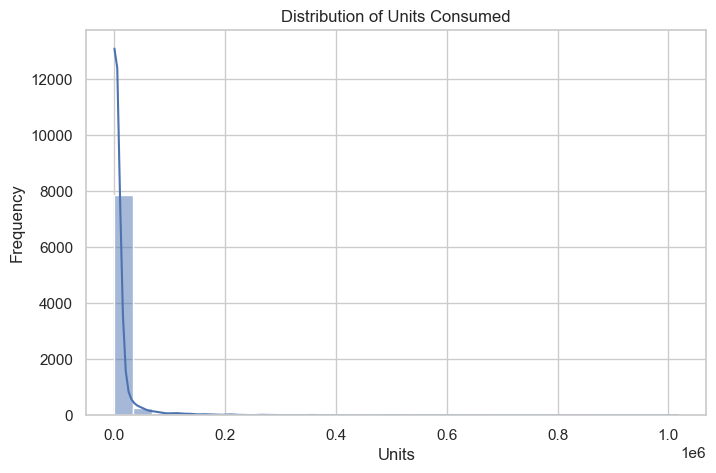

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Distribution of Units
plt.figure(figsize=(8,5))
sns.histplot(pdf["Units"], bins=30, kde=True)
plt.title("Distribution of Units Consumed")
plt.xlabel("Units")
plt.ylabel("Frequency")
plt.show()

C:\Users\shado\AppData\Local\Temp\ipykernel_6228\2024721462.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_load.values, y=avg_load.index, palette="viridis")


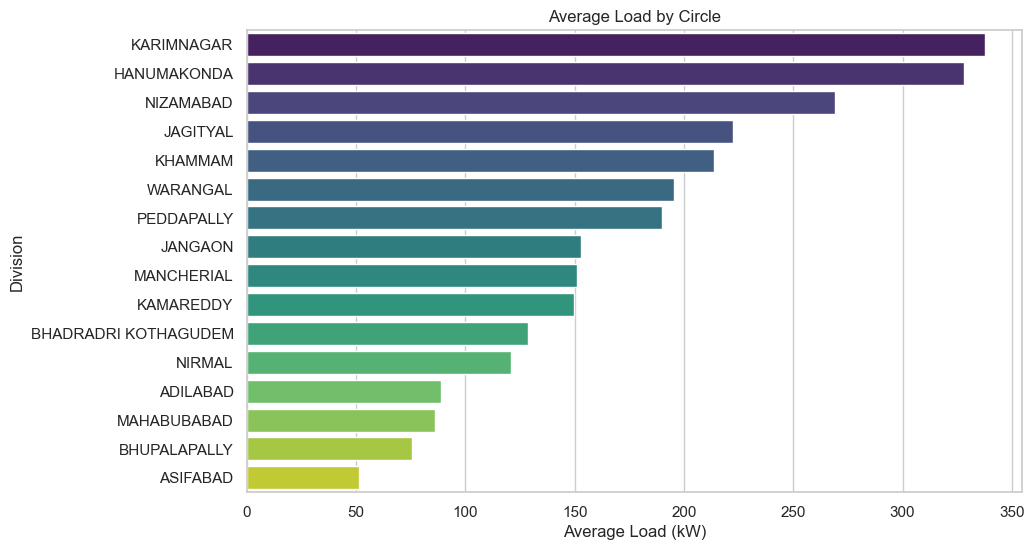

In [40]:
# Average Load by Division
avg_load = pdf.groupby("Circle")["Load"].mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=avg_load.values, y=avg_load.index, palette="viridis")
plt.title("Average Load by Circle")
plt.xlabel("Average Load (kW)")
plt.ylabel("Division")
plt.show()

C:\Users\shado\AppData\Local\Temp\ipykernel_6228\958807545.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_units.values, y=total_units.index, palette="mako")


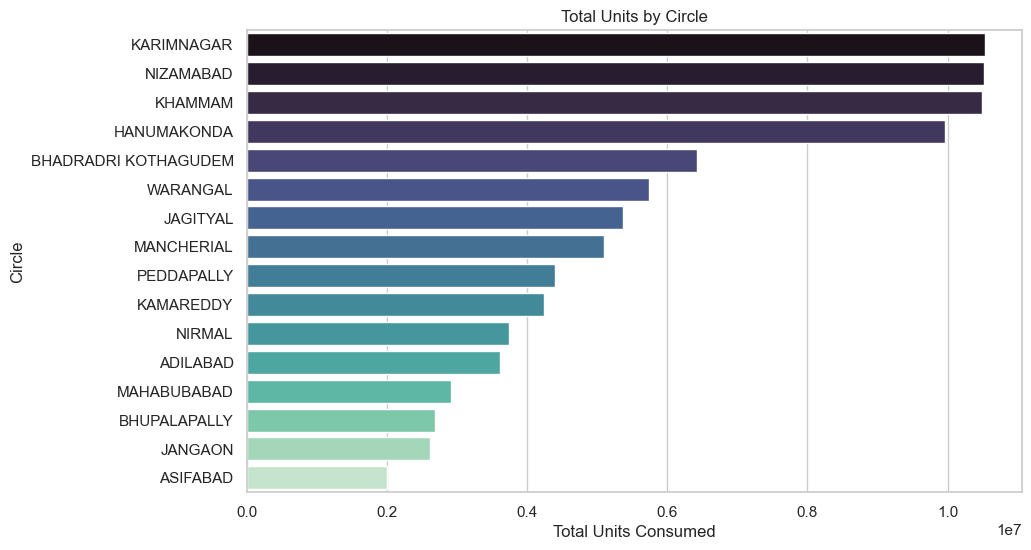

In [41]:
# Total Units by Circle
total_units = pdf.groupby("Circle")["Units"].sum().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=total_units.values, y=total_units.index, palette="mako")
plt.title("Total Units by Circle")
plt.xlabel("Total Units Consumed")
plt.ylabel("Circle")
plt.show()

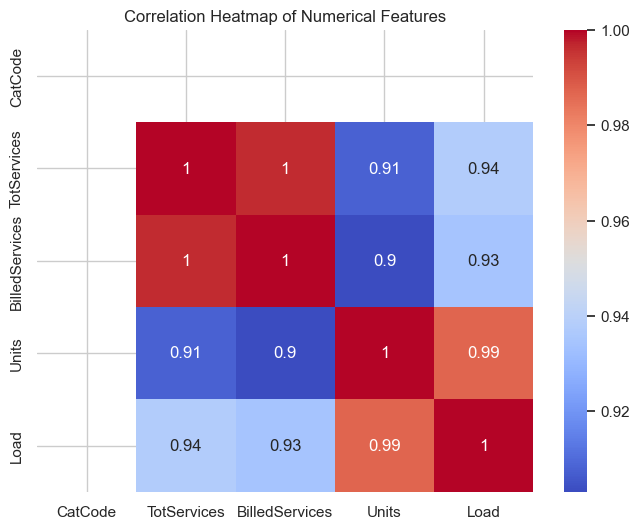

In [7]:
plt.figure(figsize=(8,6))
sns.heatmap(pdf.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


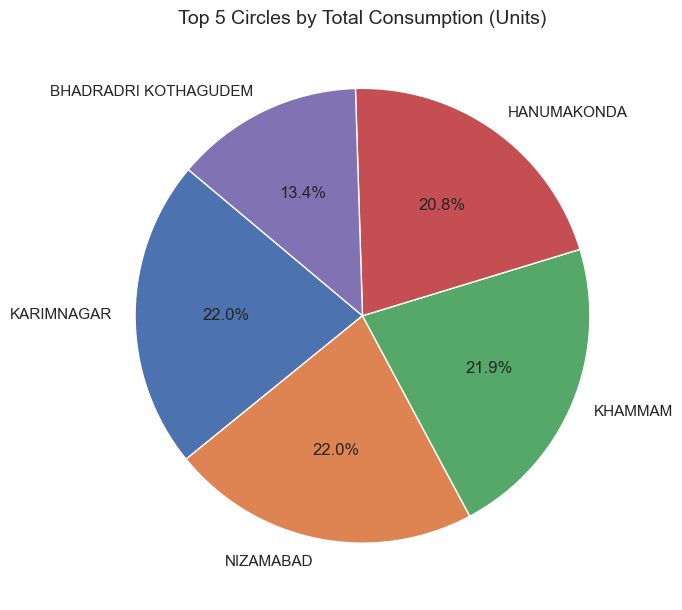

In [42]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set theme for consistent styling
sns.set_theme(style="whitegrid")

# ===============================
# 1. Top 5 Circles by Consumption (Pie Chart)
# ===============================
circle_consumption = pdf.groupby("Circle")["Units"].sum().sort_values(ascending=False)
top5_circles = circle_consumption.head(5)

plt.figure(figsize=(7, 7))
plt.pie(top5_circles, labels=top5_circles.index, autopct='%1.1f%%', startangle=140)
plt.title("Top 5 Circles by Total Consumption (Units)", fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\shado\AppData\Local\Temp\ipykernel_6228\243623286.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=circle_consumption.index, y=circle_consumption.values, palette="plasma")


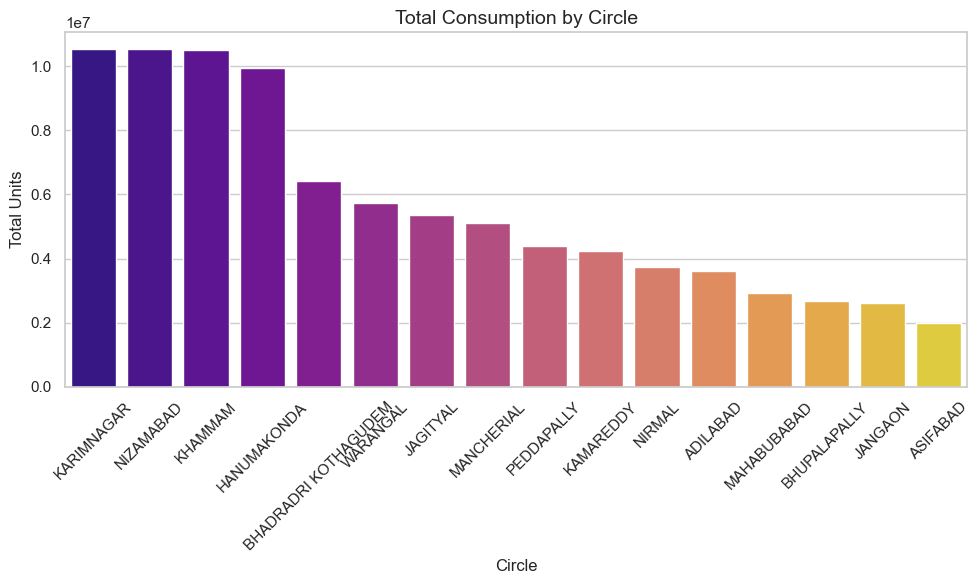

In [43]:
# ===============================
# 2. Total Consumption by Circle (Bar Chart)
# ===============================
plt.figure(figsize=(10, 6))
sns.barplot(x=circle_consumption.index, y=circle_consumption.values, palette="plasma")
plt.title("Total Consumption by Circle", fontsize=14)
plt.xlabel("Circle")
plt.ylabel("Total Units")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

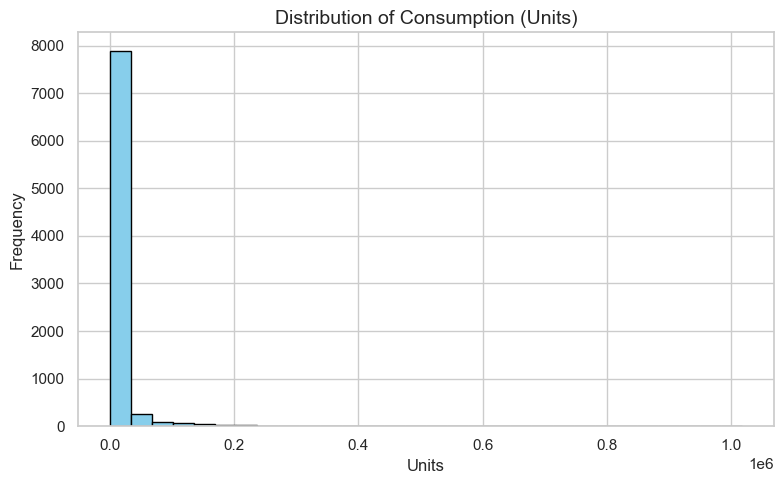

In [44]:
# ===============================
# 3. Distribution of Consumption (Histogram)
# ===============================
plt.figure(figsize=(8, 5))
plt.hist(pdf["Units"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Consumption (Units)", fontsize=14)
plt.xlabel("Units")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

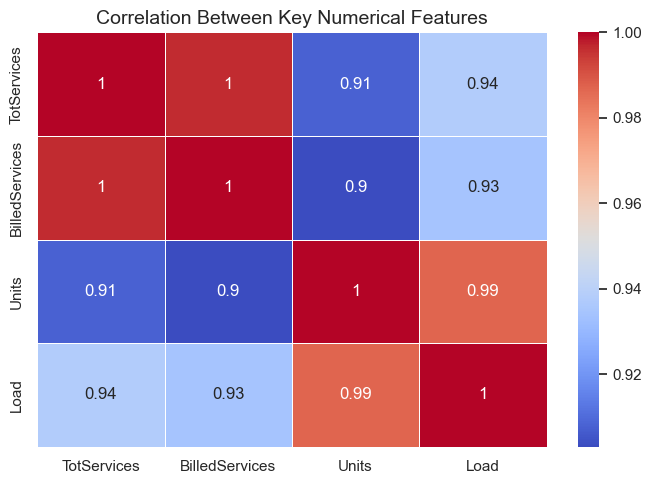

In [45]:
# ===============================
# 4. Correlation Heatmap of Numerical Features
# ===============================
plt.figure(figsize=(7, 5))
sns.heatmap(pdf[["TotServices", "BilledServices", "Units", "Load"]].corr(),
            annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Key Numerical Features", fontsize=14)
plt.tight_layout()
plt.show()

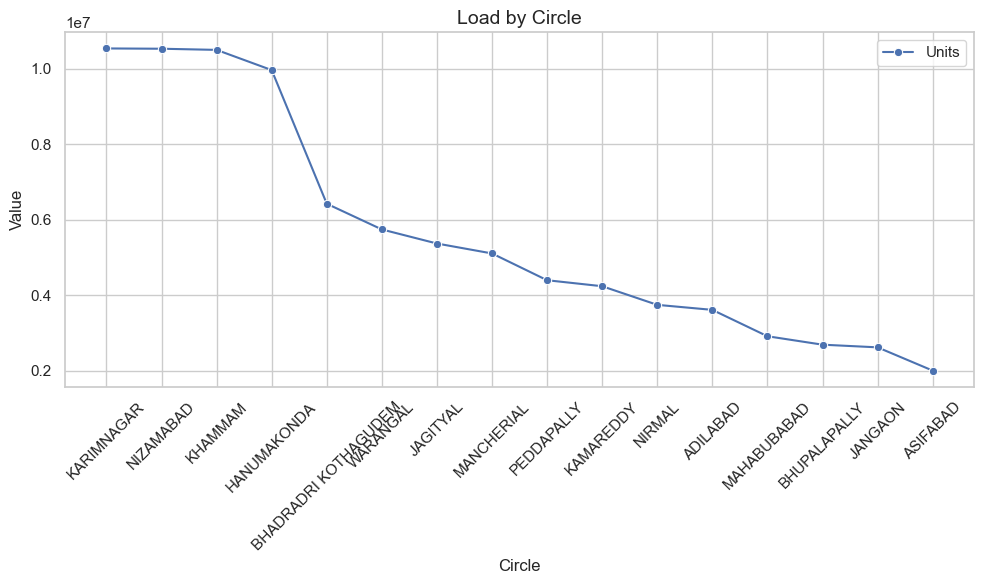

In [48]:
# ===============================
# 5. Loadvby Circle (Line Chart)
# ===============================
circle_trend = pdf.groupby("Circle")[["Units", "Load"]].sum().sort_values("Units", ascending=False)

plt.figure(figsize=(10, 6))
sns.lineplot(data=circle_trend, x=circle_trend.index, y="Units", label="Units", marker="o")
# sns.lineplot(data=circle_trend, x=circle_trend.index, y="Load", label="Load", marker="s")
plt.title("Load by Circle", fontsize=14)
plt.xlabel("Circle")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\shado\AppData\Local\Temp\ipykernel_6228\4047471273.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf, x="Circle", y="Units", palette="Set2")


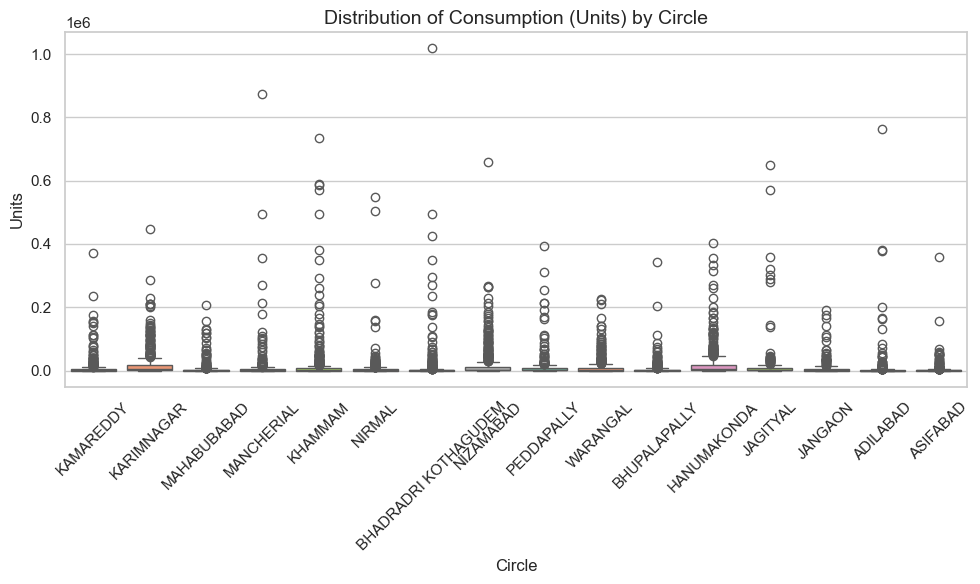

In [49]:
plt.figure(figsize=(10,6))
sns.boxplot(data=pdf, x="Circle", y="Units", palette="Set2")
plt.title("Distribution of Consumption (Units) by Circle", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\shado\AppData\Local\Temp\ipykernel_6228\2087084246.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=pdf, x="Circle", y="Load", palette="muted")


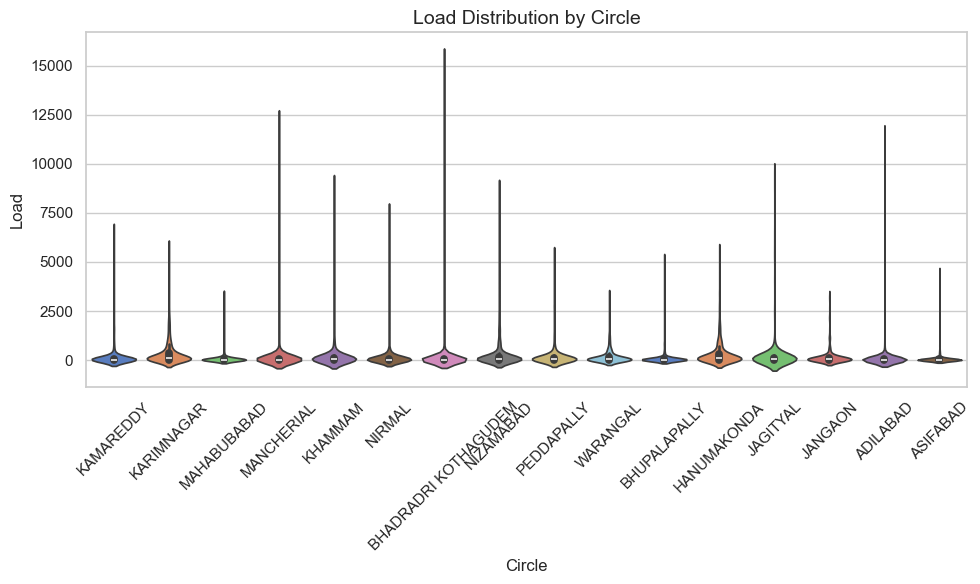

In [50]:
plt.figure(figsize=(10,6))
sns.violinplot(data=pdf, x="Circle", y="Load", palette="muted")
plt.title("Load Distribution by Circle", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.


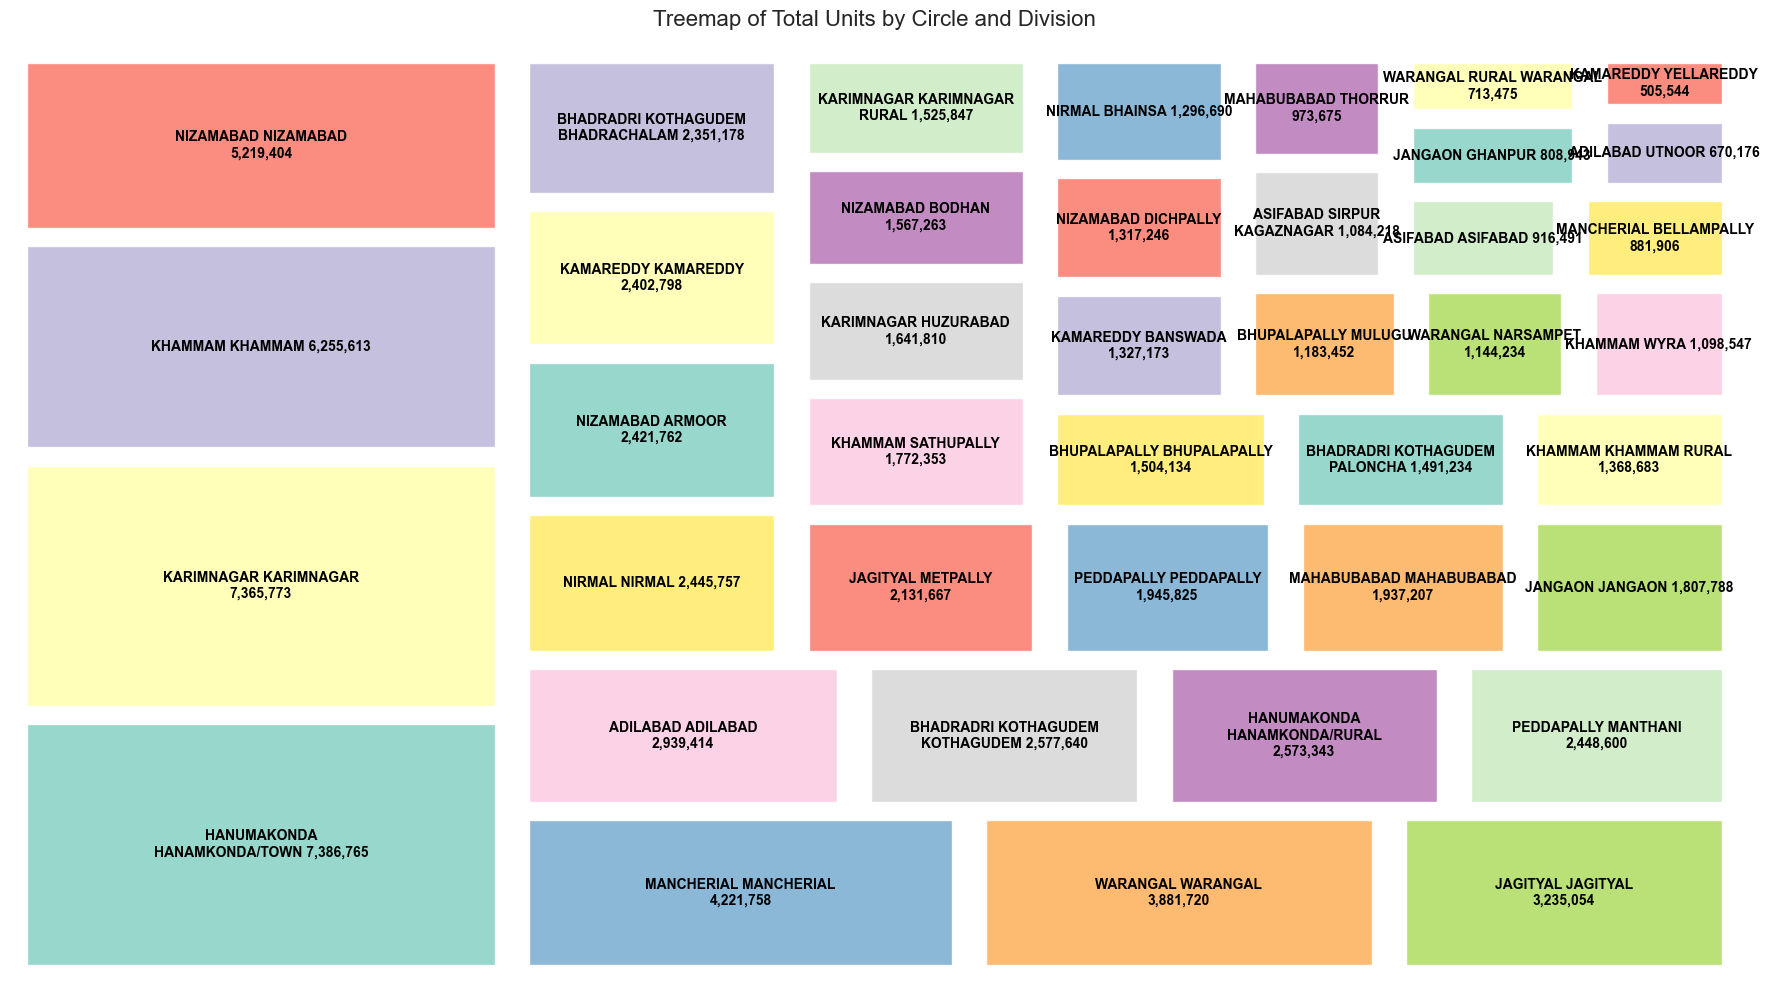

In [51]:
# # import squarify

# # circle_division = pdf.groupby(["Circle", "Division"])["Units"].sum().sort_values(ascending=False)
# # sizes = circle_division.values
# # labels = [f"{c}\n{d}\n{u:.0f}" for (c, d), u in circle_division.items()]

# # plt.figure(figsize=(12,8))
# # squarify.plot(sizes=sizes, label=labels, alpha=0.8)
# # plt.title("Treemap of Units by Circle and Division", fontsize=14)
# # plt.axis('off')
# # plt.show()

# import squarify
# import textwrap

# # Prepare data
# circle_division = (
#     pdf.groupby(["Circle", "Division"])["Units"]
#     .sum()
#     .sort_values(ascending=False)
# )

# sizes = circle_division.values
# labels_raw = [f"{c}\n{d}\n{u:,.0f}" for (c, d), u in circle_division.items()]

# # Wrap long labels to multiple lines
# labels = ['\n'.join(textwrap.wrap(label, width=25)) for label in labels_raw]

# # --- Plot ---
# plt.figure(figsize=(18, 10))  # Expanded figure size
# squarify.plot(
#     sizes=sizes,
#     label=labels,
#     alpha=0.85,
#     pad=True,
#     text_kwargs={'fontsize': 10, 'weight': 'bold'}
# )

# plt.title("Treemap of Total Units by Circle and Division", fontsize=16, pad=20)
# plt.axis("off")
# plt.tight_layout()
# plt.show()


import squarify
import matplotlib.pyplot as plt
import textwrap

# Prepare data
circle_division = (
    pdf.groupby(["Circle", "Division"])["Units"]
    .sum()
    .sort_values(ascending=False)
)

sizes = circle_division.values
labels_raw = [f"{c}\n{d}\n{u:,.0f}" for (c, d), u in circle_division.items()]
labels = ['\n'.join(textwrap.wrap(label, width=25)) for label in labels_raw]

# --- Use a bright color palette ---
# You can change the palette name for different looks: 'tab20', 'Set3', 'Pastel1', 'Paired', 'Accent'
import seaborn as sns
colors = sns.color_palette("Set3", n_colors=len(sizes))

# --- Plot ---
plt.figure(figsize=(18, 10))
squarify.plot(
    sizes=sizes,
    label=labels,
    color=colors,
    alpha=0.9,
    pad=True,
    text_kwargs={'fontsize': 10, 'weight': 'bold', 'color': 'black'}
)

plt.title("Treemap of Total Units by Circle and Division", fontsize=16, pad=20)
plt.axis("off")
plt.tight_layout()
plt.show()


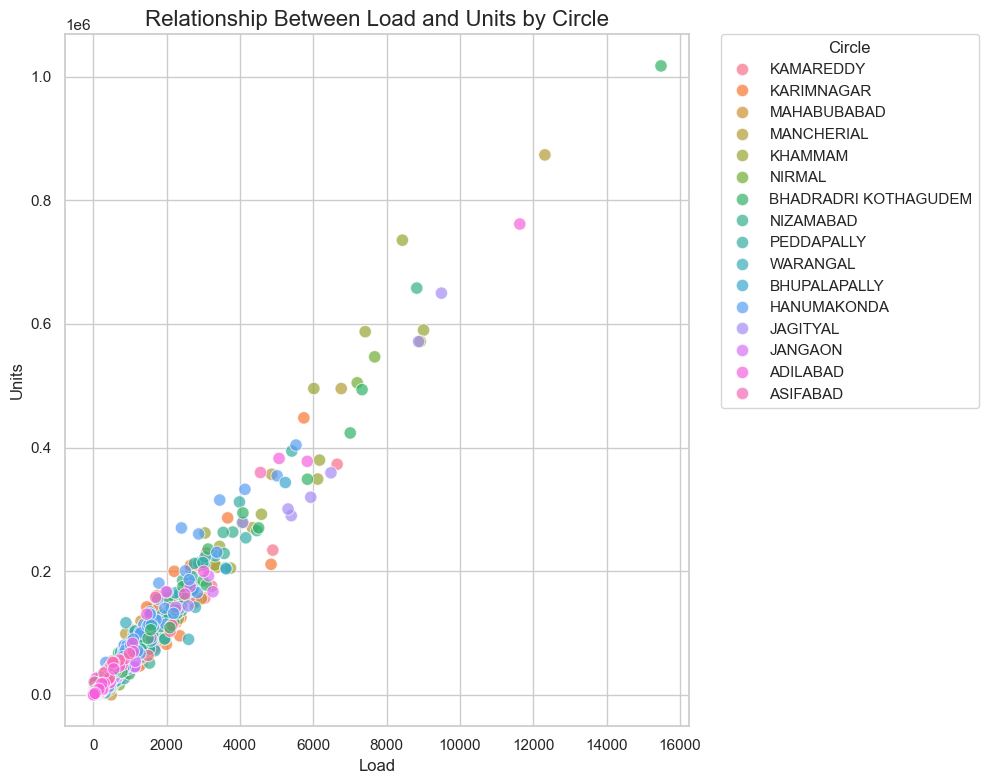

In [52]:
# plt.figure(figsize=(8,6))
# sns.scatterplot(data=pdf, x="Load", y="Units", hue="Circle", alpha=0.7)
# plt.title("Relationship Between Load and Units by Circle", fontsize=14)
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=pdf,
    x="Load",
    y="Units",
    hue="Circle",
    alpha=0.7,
    s=80,            # Slightly larger points
    edgecolor="w",   # White border for clarity
)

plt.title("Relationship Between Load and Units by Circle", fontsize=16)
plt.xlabel("Load", fontsize=12)
plt.ylabel("Units", fontsize=12)


# Move legend outside the plot
plt.legend(title="Circle", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make space on the right for legend
plt.show()


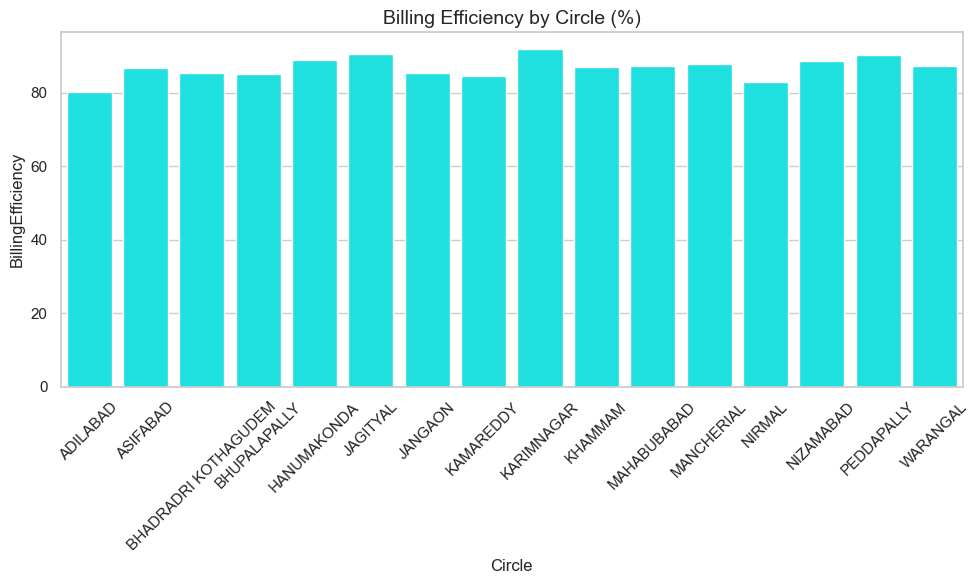

In [53]:
billed_ratio = pdf.groupby("Circle")[["TotServices", "BilledServices"]].sum().reset_index()
billed_ratio["BillingEfficiency"] = billed_ratio["BilledServices"] / billed_ratio["TotServices"] * 100

plt.figure(figsize=(10,6))
sns.barplot(data=billed_ratio, x="Circle", y="BillingEfficiency", color="cyan")
plt.title("Billing Efficiency by Circle (%)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


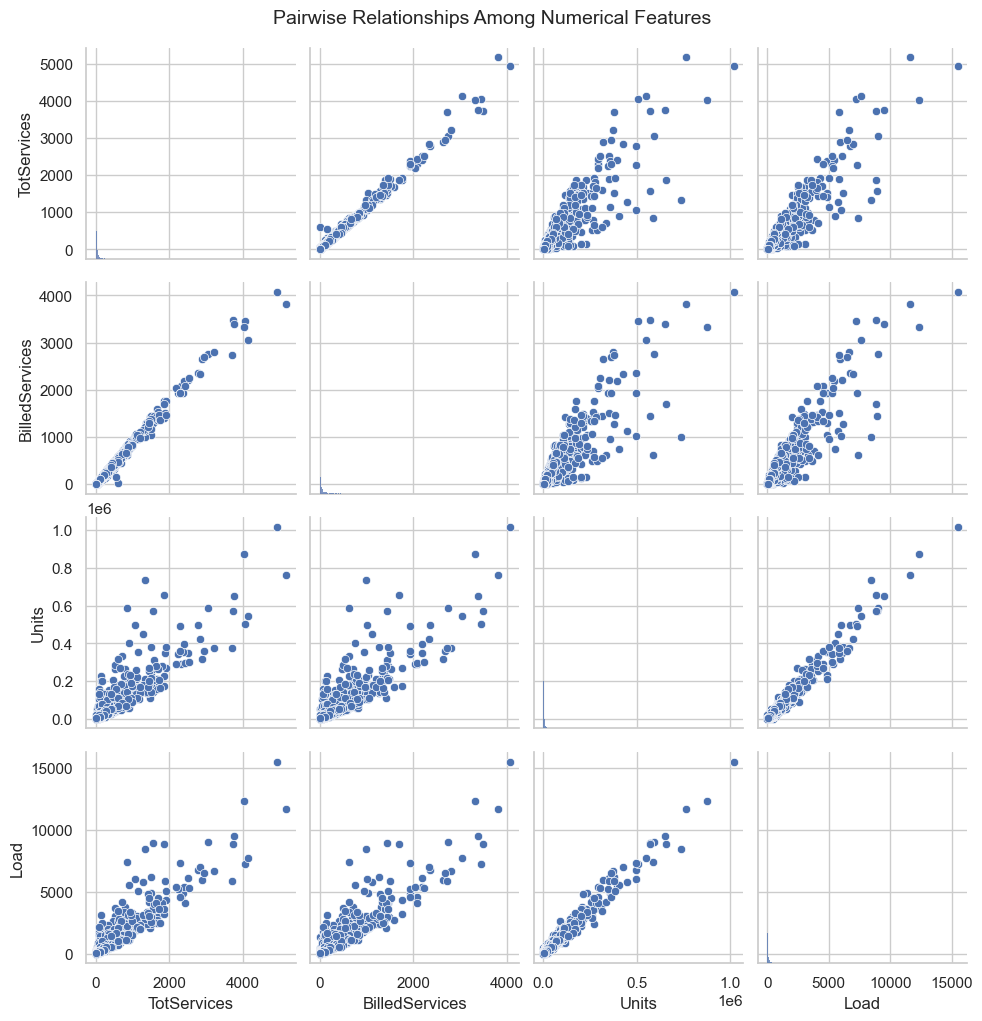

In [54]:
sns.pairplot(pdf[["TotServices", "BilledServices", "Units", "Load"]])
plt.suptitle("Pairwise Relationships Among Numerical Features", y=1.02, fontsize=14)
plt.show()


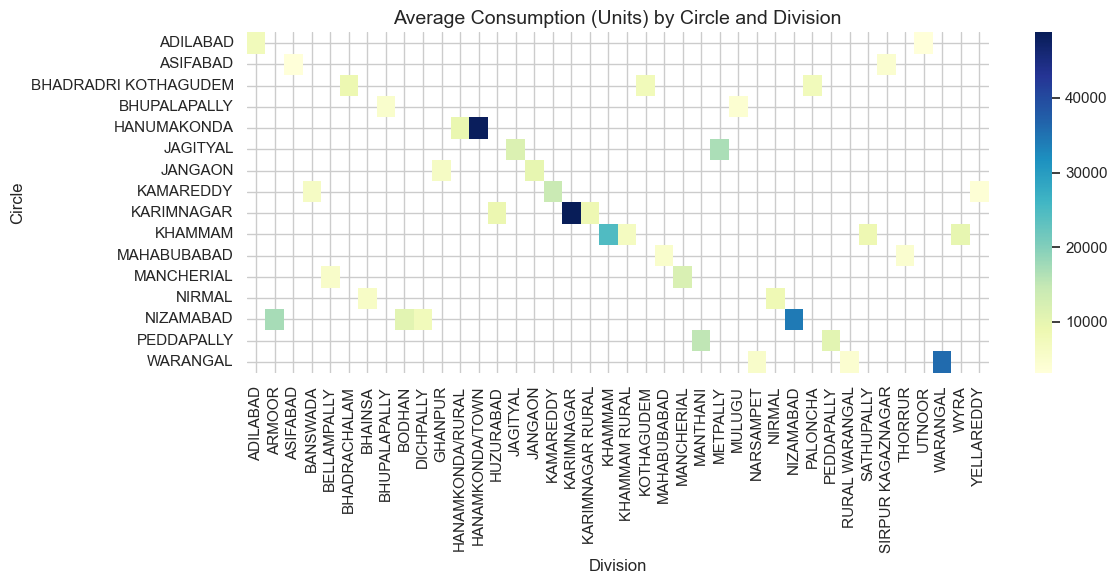

In [55]:
pivot = pdf.groupby(["Circle", "Division"])["Units"].mean().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="YlGnBu", annot=False)
plt.title("Average Consumption (Units) by Circle and Division", fontsize=14)
plt.tight_layout()
plt.show()
